<a href="https://colab.research.google.com/github/rroxy08/CE888/blob/master/assignment2/assign2_dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
##########################ieee-fraud-detection###########################
############## Dataset-1 features- 394 #############################################

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random as rd
import os
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB 
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from scipy.stats import entropy
from sklearn.decomposition import PCA
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier


#drive.mount('/content/gdrive')
os.environ['KAGGLE_USERNAME'] = "khaledabegum"
os.environ['KAGGLE_KEY'] = "3ab75f2bb1de78f9addea9a3f5079ec9"


In [3]:
!pip install densratio
from densratio import densratio

In [4]:
!kaggle competitions download --force -c ieee-fraud-detection


  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 53.5MB/s]
 94% 49.0M/52.2M [00:00<00:00, 35.2MB/s]
100% 52.2M/52.2M [00:00<00:00, 56.6MB/s]
 82% 48.0M/58.3M [00:00<00:00, 29.9MB/s]
100% 58.3M/58.3M [00:00<00:00, 66.8MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 165MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 106MB/s]


In [5]:
from zipfile import ZipFile

file_names = ["/content/train_transaction.csv.zip","/content/test_transaction.csv.zip"]

for file_name in file_names:
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('done')

done
done


In [0]:
def read_data():
  root_path1 = '/content/train_transaction.csv' 
  root_path2 = '/content/test_transaction.csv' 

  df_train_t=pd.read_csv(root_path1)
  df_test_t=pd.read_csv(root_path2)
  return process_data(df_train_t, df_test_t)


In [0]:
#preprocessing of data, fillup the NAN value. Since 'year' data types are float so mode is used to fill NAN samples.
def process_data(df_train_t, df_test_t):
  df_tr=df_train_t.sample(100000)
  df_ts=df_test_t.sample(100000)

  ## Label encoding for string/categorical values
  number = LabelEncoder()
  for i in df_tr.columns:
      if (df_tr[i].dtype == 'object'):
        df_tr[i] = number.fit_transform(df_tr[i].astype('str'))
        df_tr[i] = df_tr[i].astype('object')

  for i in df_ts.columns:
      if (df_ts[i].dtype == 'object'):
        df_ts[i] = number.fit_transform(df_ts[i].astype('str'))
        df_ts[i] = df_ts[i].astype('object')


  for i in df_tr.columns:
      if (df_tr[i].dtype == 'object'):
        df_tr[i] = df_tr[i].fillna(df_tr[i].mode().iloc[0])
      if (df_tr[i].dtype == 'int'or df_tr[i].dtype == 'float'):
        df_tr[i] = df_tr[i].fillna(np.mean(df_tr[i]))

  for i in df_ts.columns:
      if (df_ts[i].dtype == 'object'):
        df_ts[i] = df_ts[i].fillna(df_ts[i].mode().iloc[0])
      if (df_ts[i].dtype == 'int' or df_ts[i].dtype == 'float'):
        df_ts[i] = df_ts[i].fillna(np.mean(df_ts[i]))
  return df_tr,df_ts

In [0]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

In [0]:
def data_histogram(df_tr,df_ts):
  training=df_tr.copy()
  testing=df_ts.copy()

  bin_val=10
  x = np.linspace( 0, 10, 45000)
  column_shift=dict()

  for i in range(len(training.columns)):
    col=training.columns[i]
    if(col !='isFraud'):
      hist_1, bins1 = np.histogram(training[col], bins=bin_val) 
      hist_2, bins2 = np.histogram(testing[col], bins=bin_val)
    
      hist_int=return_intersection(hist_1, hist_2)
      if(hist_int<0.9 and hist_int>0.0):
        column_shift[col]=hist_int
        
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(121) 
        ax1.hist(training[col], bins=bin_val, color='blue',label='train data',alpha=0.2) 
        ax1.hist(testing[col], bins=bin_val, color='red',label='test data', alpha=0.2)
        ax1.plot(bins1[0:bin_val],hist_1,'--') 
        ax1.plot(bins2[0:bin_val],hist_2,'--')
        ax1.set_title('column- '+col+' - '+ str(hist_int)) 
        ax1.legend()
        
  return column_shift


In [0]:
def data_validation(df_tr,df_ts):
  df_tr['is_test'] = range(1, len(df_tr) + 1)
  df_ts['is_test'] = range(1, len(df_ts) + 1)

  df_tr['is_test'] = 0
  df_ts['is_test'] = 1

  if('isFraud' in df_tr.columns):
    del df_tr['isFraud']

  df_merge=pd.concat([df_tr,df_ts])

  #concat([df_tr_new, df_ts_new], sort = False, join='inner')
  if('TransactionID' in df_merge.columns):
    del df_merge['TransactionID']

  Y=df_merge['is_test']
  if('is_test' in df_merge.columns):
    del df_merge['is_test']

  #print (Y.value_counts())

  Xtr, Xts, ytr, yts = train_test_split(df_merge,Y, test_size=0.2, random_state=0)
  return Xtr,Xts,ytr,yts

In [0]:
def naive_bayes_classifier(Xtr,ytr,Xts,yts,density):
  clf = GaussianNB()
  if(density=='none'):
    clf.fit(Xtr,ytr) 
  else:
    clf.fit(Xtr,ytr,sample_weight=density) 
  #clf.fit(Xtr, ytr)
  y_pred=clf.predict(Xts)
  acc_scr=accuracy_score(yts, y_pred)
  #print("ROC-AUC: ",accuracy_score(yts, y_pred))
  scores=clf.score(Xts,yts)
  cross_scores=cross_val_score(clf,Xts,yts,cv=10)

  return cross_scores,acc_scr,scores


In [0]:
from keras.regularizers import l1
def neural_classifier_model():
  
  #X_train=np.array(X_train)
  dim= feature_num
  #unit=int(dim/2)
  
  classifier = Sequential()
  #First Hidden Layer
  classifier.add(Dense(units=400, activation='relu', input_dim=dim, kernel_initializer='random_normal',activity_regularizer=l1(0.4))) #
  #Second  Hidden Layer
  classifier.add(Dense(units=200,activation='relu', kernel_initializer='random_normal', activity_regularizer=l1(0.4)))
   #Third  Hidden Layer
  classifier.add(Dense(units=100,activation='relu', kernel_initializer='random_normal', activity_regularizer=l1(0.4)))
  #Dropout
  #classifier.add(Dropout(0.6))
  #Output Layer
  classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

  #Compiling the neural network
  classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])   #sparse_categorical_crossentropy''
  return classifier


In [0]:
def neural_classifier(X_train, y_train,X_test,y_test,density):
  #len(np.array(X_train))
  #classifier=neural_classifier_model()
  classifier = KerasClassifier(build_fn=neural_classifier_model)

  if(density=='none'):
    clf_fit=classifier.fit(X_train, y_train,validation_data=[X_test,y_test],epochs=2)
  else:
    clf_fit=classifier.fit(X_train, y_train, validation_data=[X_test,y_test],sample_weight=density,epochs=2)
    
  y_pred=classifier.predict(X_test)
  y_pred=(y_pred>0.5)
  acc=accuracy_score(y_test, y_pred)
  scores=np.mean(clf_fit.history['accuracy'])

  cross_scores=cross_val_score(classifier,X_test,y_test,cv=10)

  return cross_scores,acc,scores
  
   

In [0]:
def data_density_ratio(Xtr,Xts):
  arr_train=np.array(Xtr)
  arr_test=np.array(Xts)

  # Estimate the density ratio w
  dratio =densratio(arr_train,arr_test, kernel_num=5)
  density_ratio = dratio.compute_density_ratio(arr_train)
  return density_ratio

In [0]:
def data_PCA(Xtr,Xts,comp_num):
  # Make an instance of the Model
  pca = PCA(n_components=comp_num)
  fit= pca.fit(Xtr)

  trainX_pca = pca.transform(Xtr)
  testX_pca  = pca.transform(Xts)

  return np.array(trainX_pca), np.array(testX_pca)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

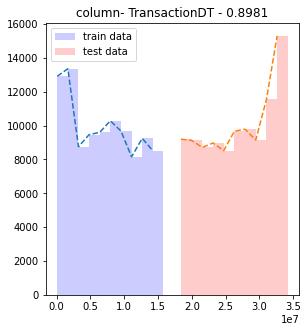

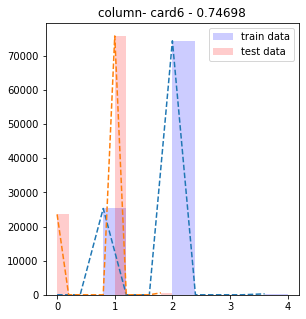

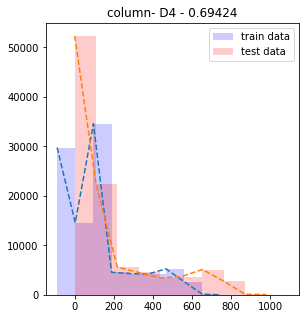

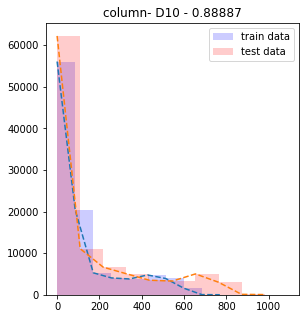

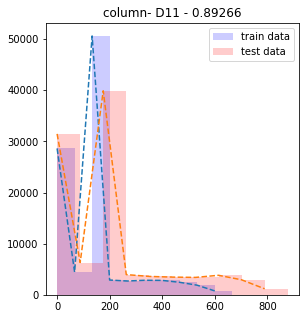

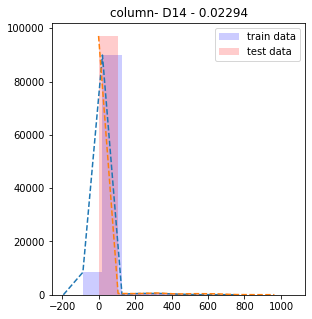

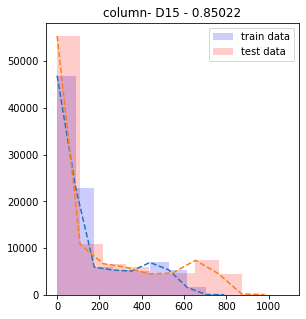

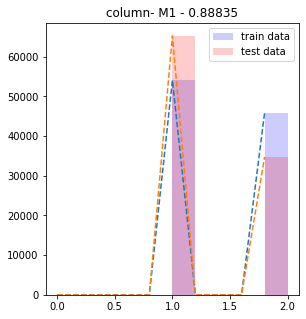

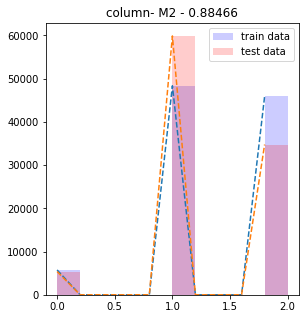

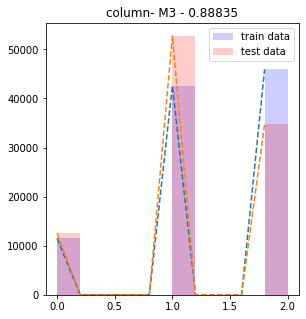

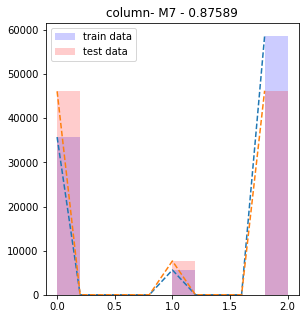

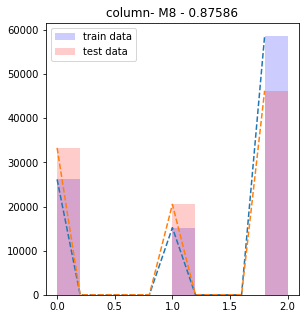

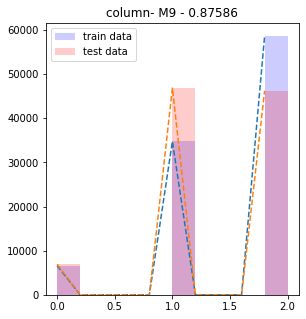

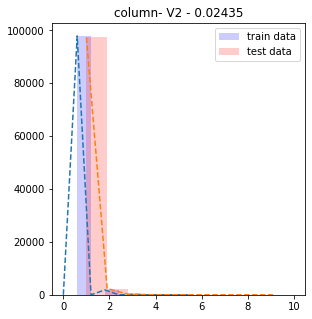

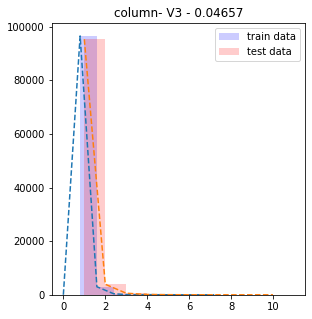

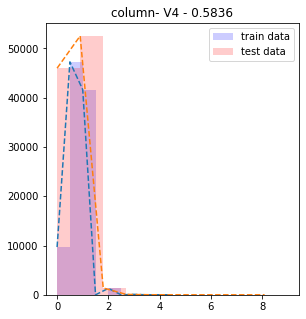

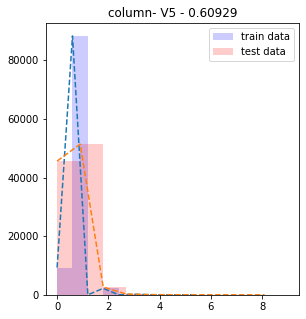

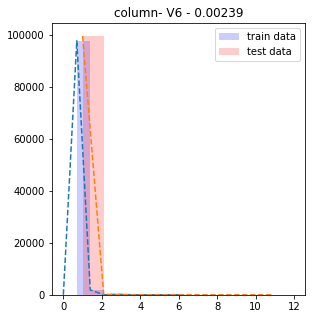

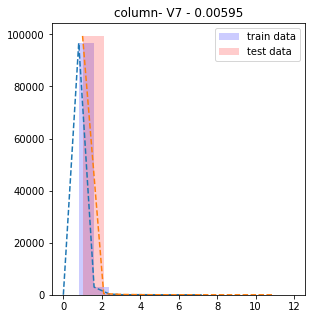

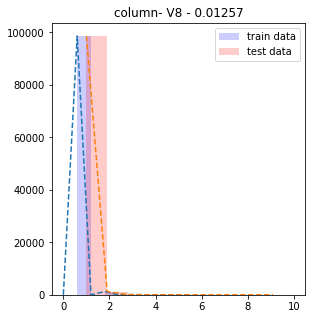

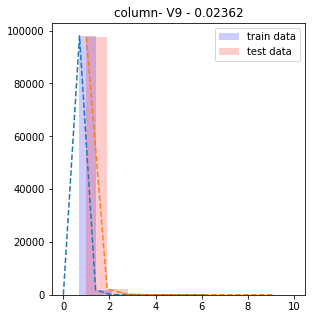

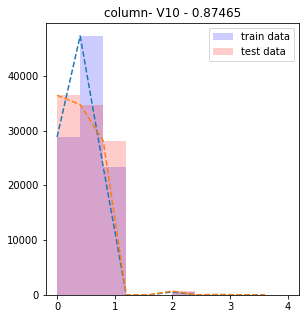

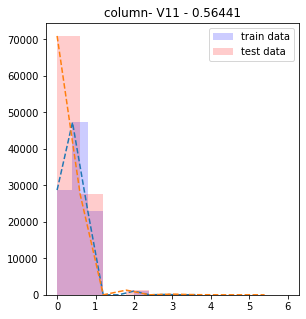

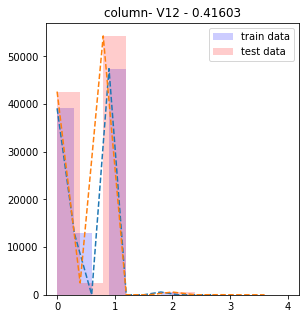

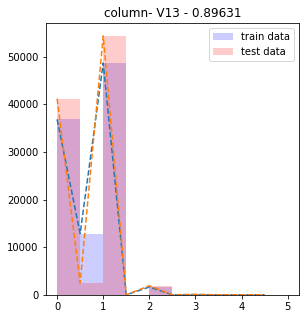

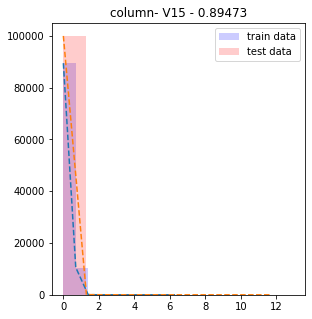

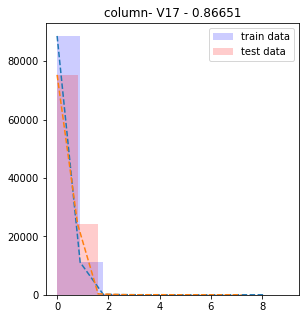

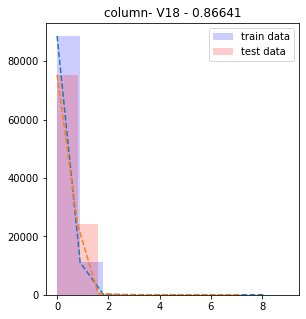

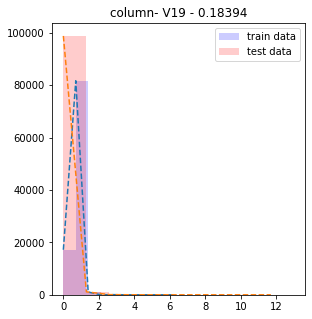

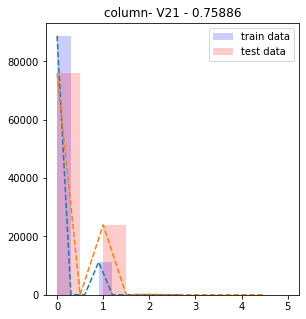

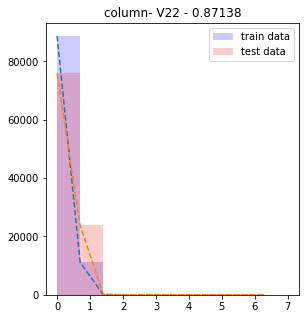

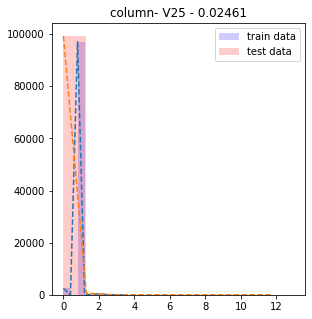

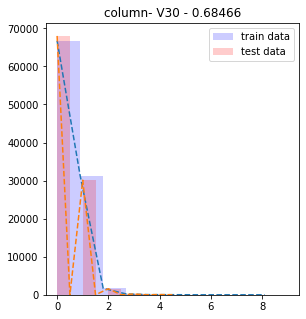

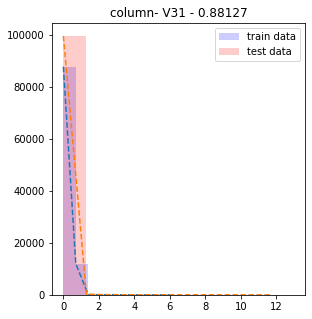

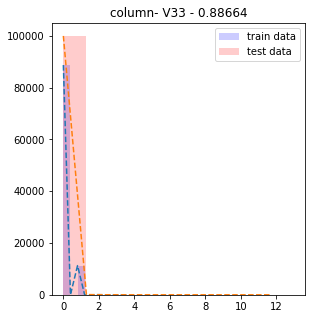

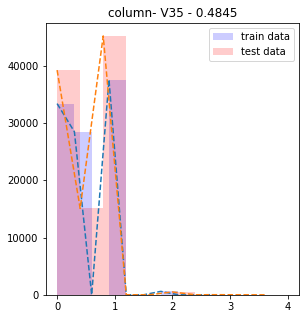

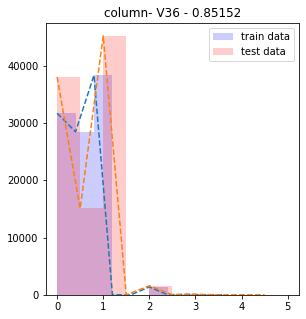

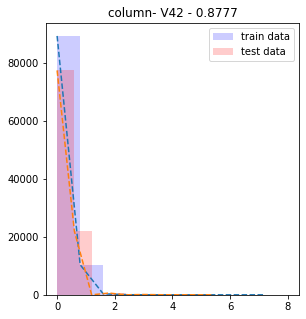

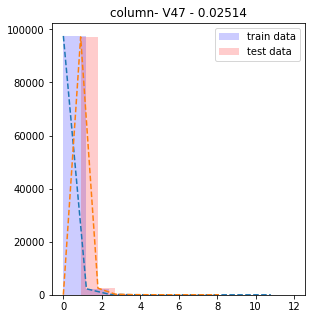

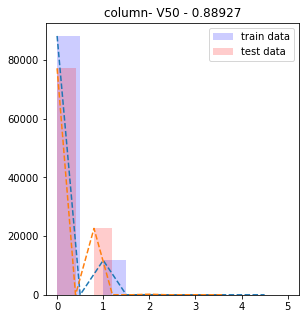

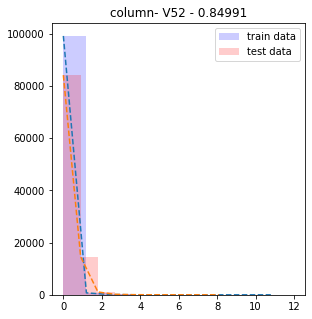

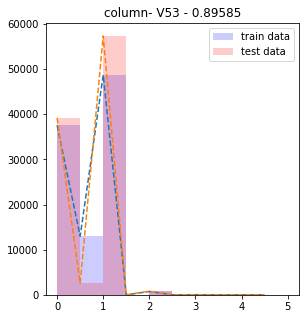

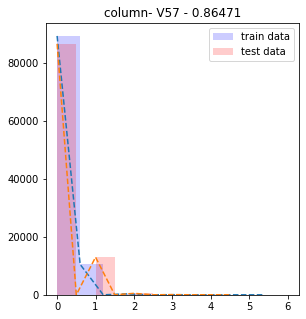

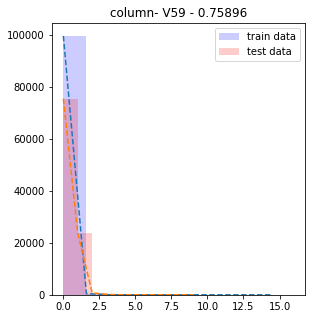

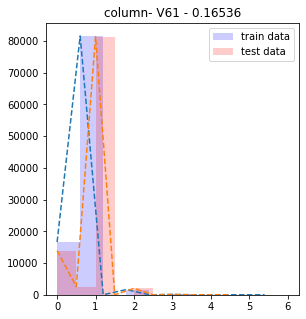

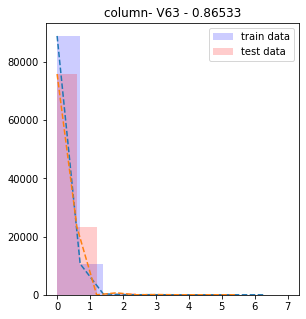

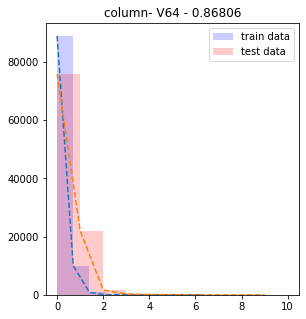

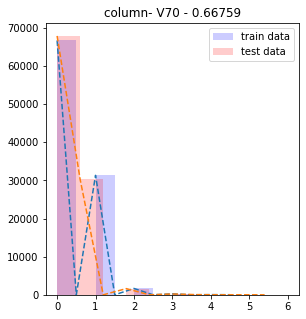

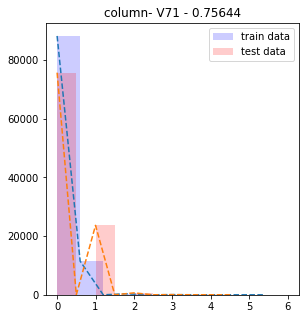

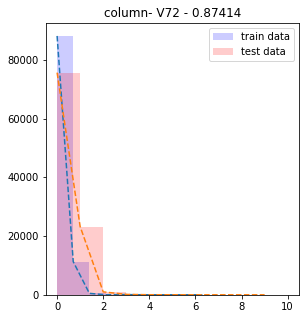

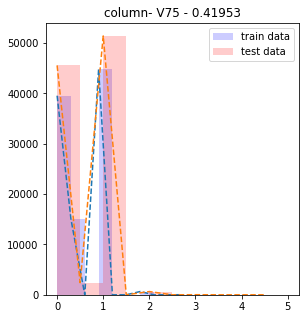

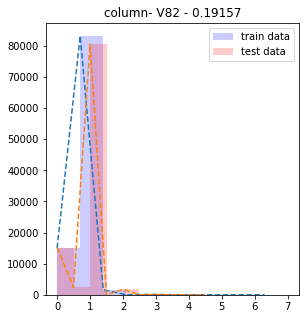

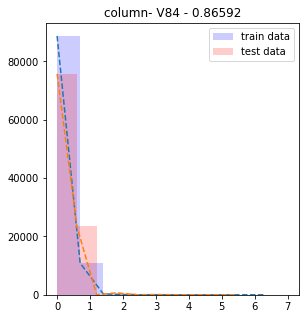

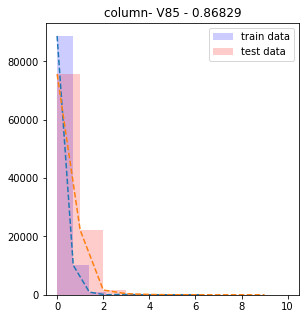

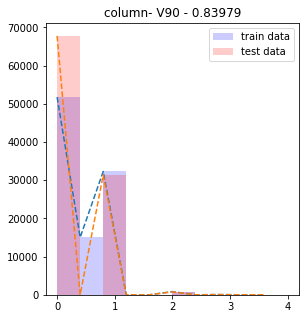

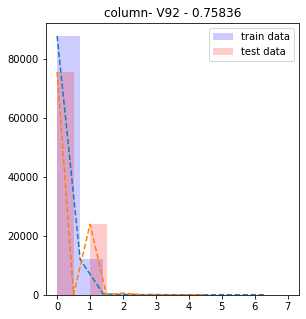

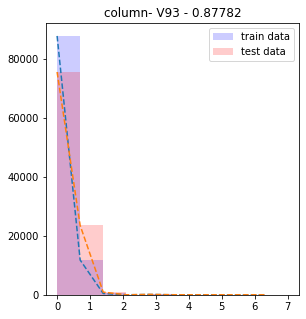

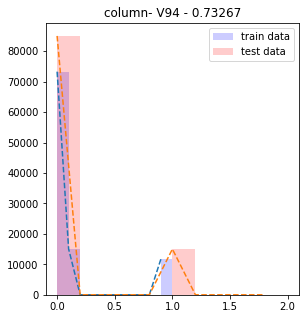

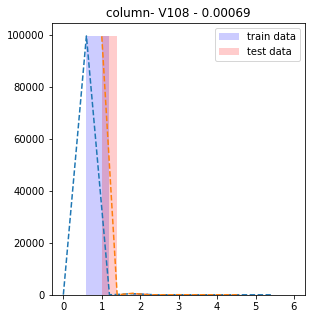

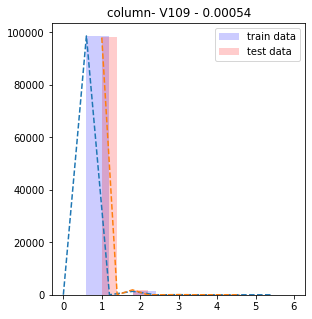

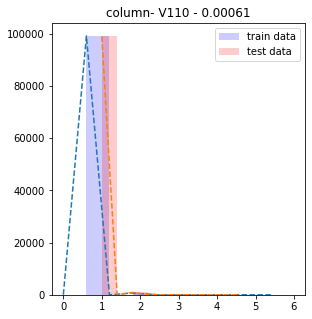

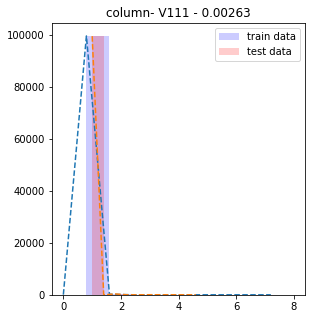

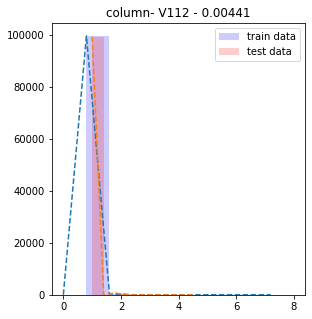

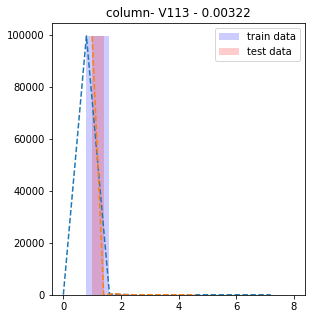

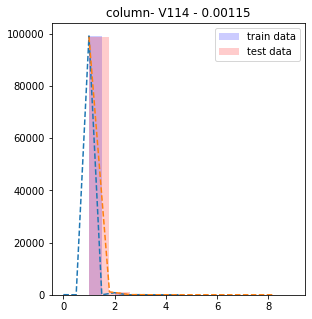

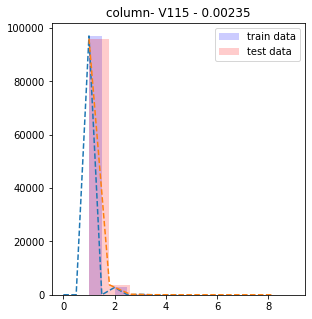

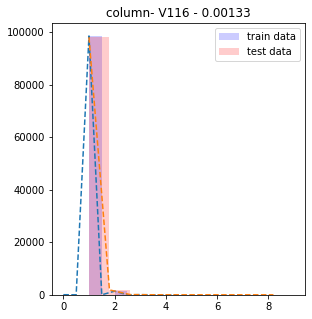

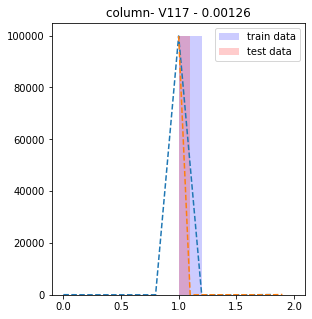

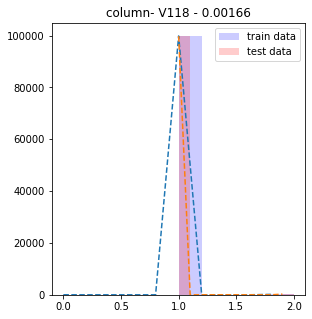

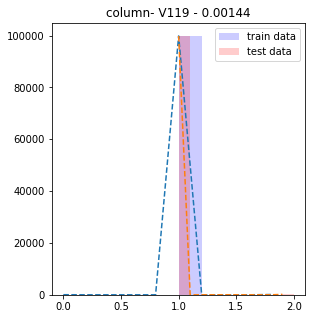

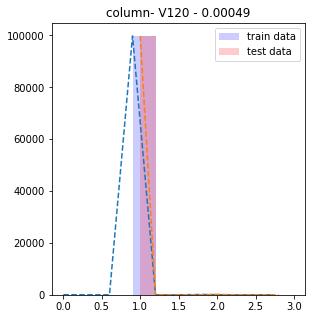

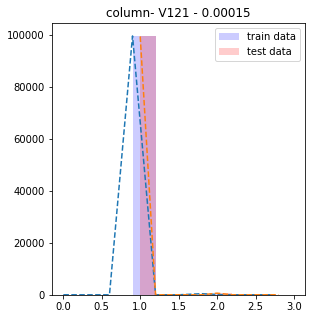

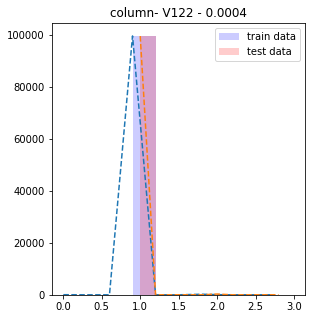

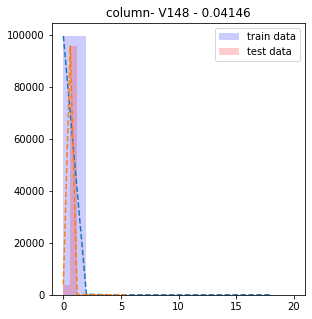

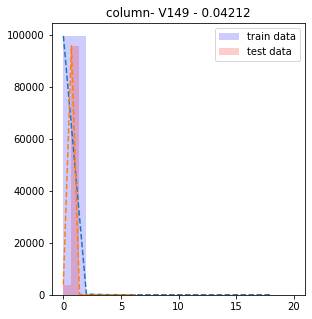

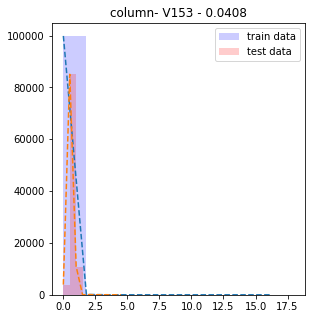

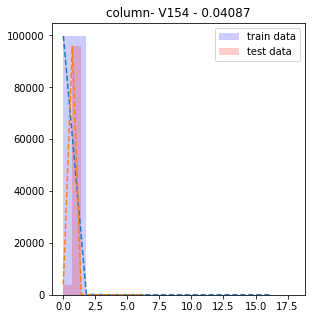

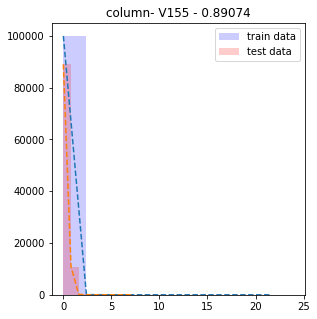

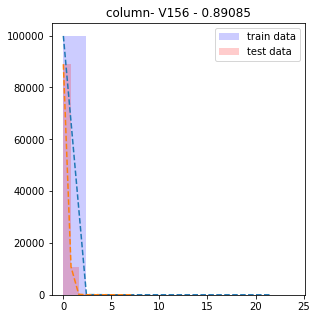

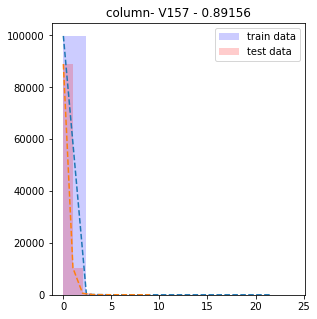

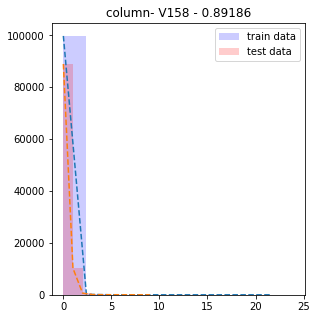

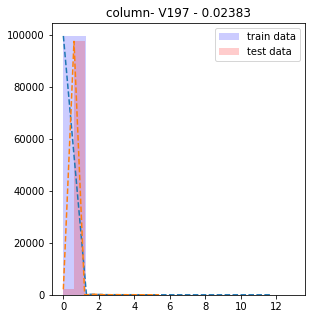

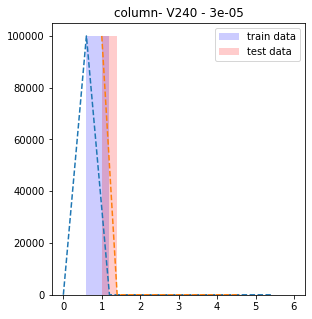

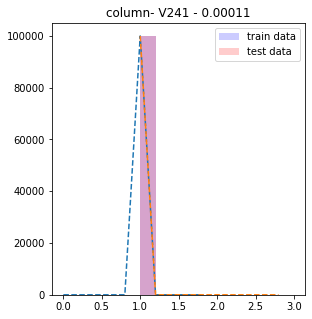

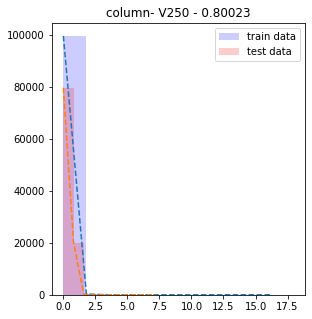

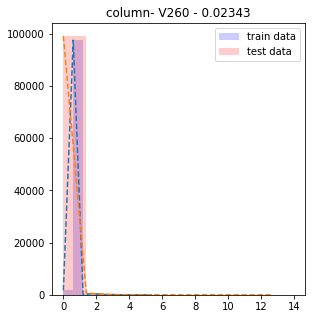

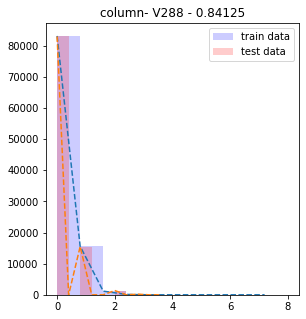

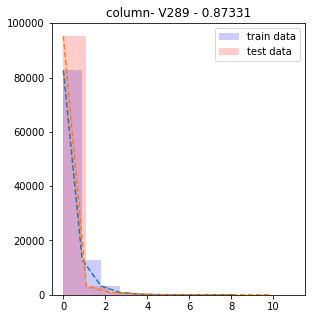

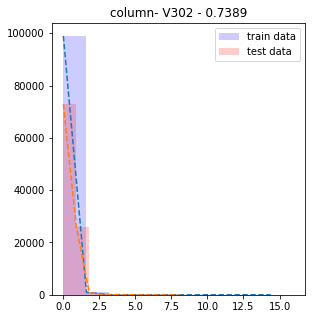

In [16]:
#Main function call.........
df_train, df_test =read_data()
#df_train, df_test=process_data(df_train, df_test)
column_shift=[]
column_Shift_dens=[]
##################################covariate shift detection through histogram visualization, and histogram intersection#################
column_shift=data_histogram(df_train,df_test)
################################################# generate train and velidation dataset###############################
Xtr,Xts,ytr,yts = data_validation(df_train,df_test)


In [17]:
print("Number of Columns with covariate shift are:",len(column_shift))

Number of Columns with covariate shift are: 89


In [18]:
#classifiers' performance with covariate shift data
feature_num=len(Xtr.columns)
cross_nb,accuracy_nb,score_nb=naive_bayes_classifier(Xtr,ytr,Xts,yts,'none')
print("Learning accuracy of Naive Bayes classifier: ",accuracy_nb)
print("Learning Score of Naive Bayes classifier: ",score_nb)
cross_nc,accuracy_nc,score_nc=neural_classifier(Xtr,ytr,Xts,yts,'none')
print("Learning accuracy of Neural Network classifier: ",accuracy_nc)
print("Learning accuracy of Neural Network classifier: ",score_nc)

Learning accuracy of Naive Bayes classifier:  0.501325
Learning Score of Naive Bayes classifier:  0.501325
Train on 160000 samples, validate on 40000 samples
Epoch 1/2
160000/160000 [==============================] - 26s 162us/step - loss: 10510113.6394 - accuracy: 0.4988 - val_loss: 26.1663 - val_accuracy: 0.5022
Epoch 2/2
160000/160000 [==============================] - 25s 158us/step - loss: 2.3551 - accuracy: 0.4981 - val_loss: 24.5874 - val_accuracy: 0.4978
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 40us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 42us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s

In [19]:
print("Number of columns with covariate shift ",len(column_shift))
print(column_shift)
Xtr_drop=Xtr.copy()
Xts_drop=Xts.copy()
for col in column_shift:
  if(column_shift[col]<0.5):
    if(col in Xtr_drop.columns):
      del Xtr_drop[col]
      del Xts_drop[col]

Number of columns with covariate shift  89
{'TransactionDT': 0.8981, 'card6': 0.74698, 'D4': 0.69424, 'D10': 0.88887, 'D11': 0.89266, 'D14': 0.02294, 'D15': 0.85022, 'M1': 0.88835, 'M2': 0.88466, 'M3': 0.88835, 'M7': 0.87589, 'M8': 0.87586, 'M9': 0.87586, 'V2': 0.02435, 'V3': 0.04657, 'V4': 0.5836, 'V5': 0.60929, 'V6': 0.00239, 'V7': 0.00595, 'V8': 0.01257, 'V9': 0.02362, 'V10': 0.87465, 'V11': 0.56441, 'V12': 0.41603, 'V13': 0.89631, 'V15': 0.89473, 'V17': 0.86651, 'V18': 0.86641, 'V19': 0.18394, 'V21': 0.75886, 'V22': 0.87138, 'V25': 0.02461, 'V30': 0.68466, 'V31': 0.88127, 'V33': 0.88664, 'V35': 0.4845, 'V36': 0.85152, 'V42': 0.8777, 'V47': 0.02514, 'V50': 0.88927, 'V52': 0.84991, 'V53': 0.89585, 'V57': 0.86471, 'V59': 0.75896, 'V61': 0.16536, 'V63': 0.86533, 'V64': 0.86806, 'V70': 0.66759, 'V71': 0.75644, 'V72': 0.87414, 'V75': 0.41953, 'V82': 0.19157, 'V84': 0.86592, 'V85': 0.86829, 'V90': 0.83979, 'V92': 0.75836, 'V93': 0.87782, 'V94': 0.73267, 'V108': 0.00069, 'V109': 0.00054, '

In [20]:
#classifiers' performance with covariate shift data, DROPPING features ############################
feature_num=len(Xtr_drop.columns)
print(Xtr.shape)
print(Xtr_drop.shape)
cross_nb_drop,accuracy_nb,score_nb=naive_bayes_classifier(Xtr_drop,ytr,Xts_drop,yts,'none')
print("Learning accuracy of Naive Bayes classifier: ",accuracy_nb)
print("Learning Score of Naive Bayes classifier: ",score_nb)
cross_nc_drop,accuracy_nc,score_nc=neural_classifier(Xtr_drop,ytr,Xts_drop,yts,'none')
print("Learning accuracy of Neural Network classifier: ",accuracy_nc)
print("Learning accuracy of Neural Network classifier: ",score_nc)

(160000, 392)
(160000, 354)
Learning accuracy of Naive Bayes classifier:  0.501325
Learning Score of Naive Bayes classifier:  0.501325
Train on 160000 samples, validate on 40000 samples
Epoch 1/2
160000/160000 [==============================] - 23s 147us/step - loss: 13232013.2414 - accuracy: 0.5005 - val_loss: 1.2086 - val_accuracy: 0.4978
Epoch 2/2
160000/160000 [==============================] - 23s 147us/step - loss: 1.6548 - accuracy: 0.5000 - val_loss: 0.7896 - val_accuracy: 0.5022
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 38us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 47us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 40us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==========

In [22]:
density=data_density_ratio(Xtr,Xts)

RuLSIF starting...
Searching for the optimal sigma and lambda...
sigma = 0.00100, lambda = 0.00100, score = 0.00000
sigma = 0.00100, lambda = 0.01000, score = 0.00000
sigma = 0.00100, lambda = 0.10000, score = 0.00000
sigma = 0.00100, lambda = 1.00000, score = 0.00000
sigma = 0.00100, lambda = 10.00000, score = 0.00000
sigma = 0.00100, lambda = 100.00000, score = -0.00000
sigma = 0.00100, lambda = 1000.00000, score = 0.00000
sigma = 0.00100, lambda = 10000.00000, score = -0.00000
sigma = 0.00100, lambda = 100000.00000, score = 0.00000
sigma = 0.00100, lambda = 1000000.00000, score = 0.00000
sigma = 0.00100, lambda = 10000000.00000, score = 0.00000
sigma = 0.00100, lambda = 100000000.00000, score = 0.00000
sigma = 0.00100, lambda = 1000000000.00000, score = 0.00000
sigma = 0.01000, lambda = 0.00100, score = 0.00000
sigma = 0.01000, lambda = 0.01000, score = 0.00000
sigma = 0.01000, lambda = 0.10000, score = 0.00000
sigma = 0.01000, lambda = 1.00000, score = 0.00000
sigma = 0.01000, lamb

In [23]:
feature_num=len(Xtr.columns)

cross_nb_dens,accuracy_nb_dens,score_nb_dens=naive_bayes_classifier(Xtr,ytr,Xts,yts,density)
print("Learning accuracy of Naive Bayes classifier: ",accuracy_nb_dens)
print("Learning score of Naive Bayes classifier: ",score_nb_dens)
cross_nc_dens,accuracy_nc_dens,score_nc_dens=neural_classifier(Xtr,ytr,Xts,yts,density)
print("Learning accuracy of Neural Network classifier: ",accuracy_nc_dens)
print("Learning score of Neural Network classifier: ",score_nc_dens)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Learning accuracy of Naive Bayes classifier:  0.501325
Learning score of Naive Bayes classifier:  0.501325


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


Train on 160000 samples, validate on 40000 samples
Epoch 1/2
160000/160000 [==============================] - 22s 137us/step - loss: 14663483.8260 - accuracy: 0.4991 - val_loss: 72.6342 - val_accuracy: 0.5021
Epoch 2/2
160000/160000 [==============================] - 22s 136us/step - loss: 1.1004 - accuracy: 0.5003 - val_loss: 72.4830 - val_accuracy: 0.4978
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 40us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 40us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [=======

In [21]:
###########################   PCA ##############################################################
feature_num=len(Xtr.columns)
print(feature_num)
Xtr_pca, Xts_pca = data_PCA(Xtr,Xts,feature_num)
cross_nb_pca,accuracy_nb,score_nb=naive_bayes_classifier(Xtr_pca,ytr,Xts_pca,yts,'none')
print("Learning accuracy of Naive Bayes classifier: ",accuracy_nb)
print("Learning Score of Naive Bayes classifier: ",score_nb)
cross_nc_pca,accuracy_nc,score_nc=neural_classifier(Xtr_pca,ytr,Xts_pca,yts,'none')
print("Learning accuracy of Neural Network classifier: ",accuracy_nc)
print("Learning accuracy of Neural Network classifier: ",score_nc)

392
Learning accuracy of Naive Bayes classifier:  0.746575
Learning Score of Naive Bayes classifier:  0.746575
Train on 160000 samples, validate on 40000 samples
Epoch 1/2
160000/160000 [==============================] - 23s 142us/step - loss: 10592129.3918 - accuracy: 0.5013 - val_loss: 3448897.6330 - val_accuracy: 0.4978
Epoch 2/2
160000/160000 [==============================] - 23s 141us/step - loss: 3239638.5836 - accuracy: 0.5004 - val_loss: 3313624.4832 - val_accuracy: 0.5021
Epoch 1/1
4000/4000 [==============================] - 0s 38us/step
Epoch 1/1
4000/4000 [==============================] - 0s 38us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 40us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 38us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [================

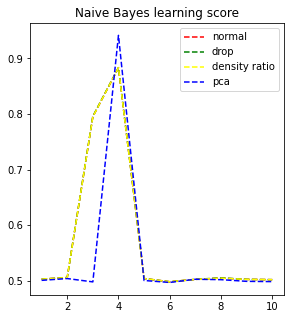

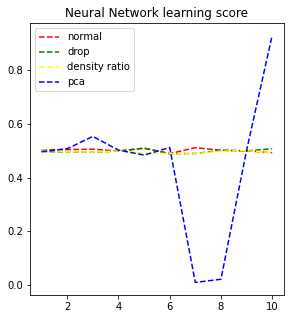

In [24]:
bin_array=[1,2,3,4,5,6,7,8,9,10]
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121) 
ax1.plot(bin_array,cross_nb,'--',color='red',label='normal') 
ax1.plot(bin_array,cross_nb_drop,'--',color='green',label='drop')
ax1.plot(bin_array,cross_nb_dens,'--',color='yellow',label='density ratio')
ax1.plot(bin_array,cross_nb_pca,'--',color='blue',label='pca')
ax1.set_title('Naive Bayes learning score') 
ax1.legend()

fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(121) 
ax2.plot(bin_array,cross_nc,'--',color='red',label='normal') 
ax2.plot(bin_array,cross_nc_drop,'--',color='green',label='drop')
ax2.plot(bin_array,cross_nc_dens,'--',color='yellow',label='density ratio')
ax2.plot(bin_array,cross_nc_pca,'--',color='blue',label='pca')
ax2.set_title('Neural Network learning score') 
ax2.legend()

In [27]:
###########################   PCA ##############################################################
feature_num=len(Xtr.columns)

g_score=[]
nn_score=[]
dim_array=[20,50,100,150,200,250,300,350,390]
for num in dim_array:
  Xtr_pca, Xts_pca = data_PCA(Xtr,Xts,feature_num)
  _,gb_acc,_=naive_bayes_classifier(Xtr_pca,ytr,Xts_pca,yts,'none')
  _,nn_acc,_=neural_classifier(Xtr_pca,ytr,Xts_pca,yts,'none')
  g_score.append(gb_acc)
  nn_score.append(nn_acc)

Train on 160000 samples, validate on 40000 samples
Epoch 1/2
160000/160000 [==============================] - 22s 137us/step - loss: 10654796.8509 - accuracy: 0.5020 - val_loss: 3300316.4336 - val_accuracy: 0.5024
Epoch 2/2
160000/160000 [==============================] - 22s 138us/step - loss: 3230485.6807 - accuracy: 0.5006 - val_loss: 3169963.1454 - val_accuracy: 0.5023
Epoch 1/1
4000/4000 [==============================] - 0s 38us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
4000/4000 [==============================] - 0s 37us/step
Epoch 1/1
4000/4000 [==============================] - 0s 43us/step
Epoch 1/1
4000/4000 [==============================] - 0s 45us/step
Epoch 1/1
4000/4000 [==============================] - 0s 47us/step
Epoch 1/1
4000/4000 [==============================] - 0s 47us/step
Epoch 1/1
4000/4000 [==============================] - 0s 40us/step
Epoch 1/1
4000/4000 [==============================] - 0s 39us/step
Epoch 1/1
40

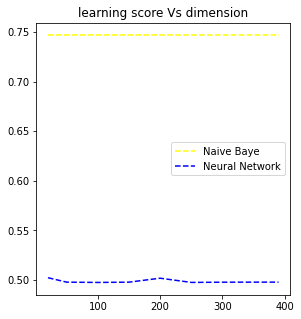

In [28]:
################## PCA dimension effect #######################
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121) 
ax1.plot(dim_array,g_score,'--',color='yellow',label='Naive Baye')
ax1.plot(dim_array,nn_score,'--',color='blue',label='Neural Network')
ax1.set_title('learning score Vs dimension') 
ax1.legend()